In [1]:
!unzip /content/drive/MyDrive/MLChallengesProject/MLProjectNASA.zip

Streaming output truncated to the last 5000 lines.
  inflating: map-proj-v3/PSP_008932_1645_RED-0125-r90.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0125.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126-brt.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126-fh.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126-fv.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126-r180.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126-r270.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126-r90.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0126.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128-brt.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128-fh.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128-fv.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128-r180.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128-r270.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128-r90.jpg  
  inflating: map-proj-v3/PSP_008932_1645_RED-0128.jpg  
 

In [2]:
import numpy as np
import torch
import os
from collections import defaultdict, Counter
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import cv2
import sklearn
import matplotlib.pyplot as plt


In [3]:
dev =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dev

device(type='cuda')

In [5]:
#Transforms for augmentation pipeline
train_transforms = A.Compose(
    [
            A.CLAHE(),
            A.RandomRotate90(),
            A.Transpose(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            A.Blur(blur_limit=3),
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.HueSaturationValue(),
            ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        ToTensorV2(),
    ]
)

In [6]:
# undersampling the majority classes to have a equal 
def majority_data_undersampler(annotations_file):
  img_labels = pd.read_csv(annotations_file, delimiter=' ',header=None, names=['name', 'class'])
  class_count = Counter(img_labels['class'].tolist())
  class_count_sorted = sorted(class_count.items(),  key=lambda pair: pair[1], reverse=True)
  min_num_class_count = class_count_sorted[-1][1]
  indices_to_be_dropped = []
  for count_tuple in class_count_sorted[:-1]:
    class_id, class_num = count_tuple[0],count_tuple[1]
    class_indices =  img_labels.index[img_labels['class'] == class_id].tolist()
    drop_indices = np.random.choice(class_indices, class_num - min_num_class_count, replace=False)
    indices_to_be_dropped.extend(drop_indices)
  
  img_labels = img_labels.drop(indices_to_be_dropped)
  img_labels.to_csv('/content/labels-map-proj-v3-undersampled.txt', header=False, sep=' ', index = False)

  

In [7]:
annotations_file = '/content/labels-map-proj-v3.txt'
majority_data_undersampler(annotations_file)

In [8]:
#Building Custom data loader 
class hiriseImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, classmap_file,  transform=None, target_transform=None):
      self.img_labels = pd.read_csv(annotations_file, delimiter=' ',header=None)
      self.class_map = pd.read_csv(classmap_file, header=None, names=['class', 'name'])
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform
  
  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
      image = cv2.imread(img_path)
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      label = self.img_labels.iloc[idx, 1]
      class_label_map = self.class_map.loc[self.class_map['class'] == label].name.item()
      if self.transform:
          image = self.transform(image=gray_image)["image"]
      if self.target_transform:
          label = self.target_transform(label)
      return image, label, class_label_map

In [9]:
train_dataset = hiriseImageDataset('/content/labels-map-proj-v3-undersampled.txt', '/content/map-proj-v3', '/content/landmarks_map-proj-v3_classmap.csv',transform=train_transforms)
valid_dataset = hiriseImageDataset('/content/labels-map-proj-v3-undersampled.txt', '/content/map-proj-v3', '/content/landmarks_map-proj-v3_classmap.csv',transform=test_transforms)

#Splitting the dataset into train and valid
num_train = len(train_dataset)
indices = list(range(num_train))
train_indices, val_indices = sklearn.model_selection.train_test_split(indices, test_size=0.33, random_state=42)
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(valid_dataset, val_indices)

In [10]:
# # Splitting image dataset
# total_count = len(model_dataset)
# train_count = int(0.7 * total_count)
# valid_count = int(0.2 * total_count)
# test_count = total_count - train_count - valid_count

# train_dataset, valid_dataset, test_dataset = random_split(
#     model_dataset, (train_count, valid_count, test_count)
# )

In [11]:
print('Size of train dataset: ', len(train_dataset))
print('Size of valid dataset: ', len(valid_dataset))
# print('Size of train dataset: ', len(test_dataset))

Size of train dataset:  1238
Size of valid dataset:  610


The shape of tensor for 50th image in train dataset:  torch.Size([1, 227, 227])
The label for 50th image in train dataset:  4
The type of image is :  int64
The image plotted is as below : 


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/functional.py:358: UserWarning: HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image
  warn(
<ipython-input-12-b607cae7017b>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(train_dataset[49][0].T, cmap='gray', vmin=0, vmax=255)


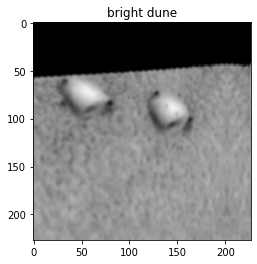

In [12]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])
print('The type of image is : ',train_dataset[49][1].dtype )
print('The image plotted is as below : ')
plt.imshow(train_dataset[49][0].T, cmap='gray', vmin=0, vmax=255)
plt.title(train_dataset[49][2])
plt.show()

In [13]:
idx_to_class = pd.read_csv('/content/landmarks_map-proj-v3_classmap.csv', index_col=0, header=None, squeeze=True).to_dict()

In [14]:
# visualizing augmentations
def visualize_augmentations(dataset, idx = 0, samples=10, cols=5, random_img = False):
  dataset = copy.deepcopy(dataset)
  # dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
  rows = samples // cols
  
      
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
  for i in range(samples):
      if random_img:
          idx = np.random.randint(1,len(dataset))
      image, lab, class_label_map = dataset[idx]
      ax.ravel()[i].imshow(image.T,cmap='gray', vmin=0, vmax=255)
      ax.ravel()[i].set_axis_off()
      ax.ravel()[i].set_title(idx_to_class[lab])
  plt.tight_layout(pad=1)
  plt.show()    

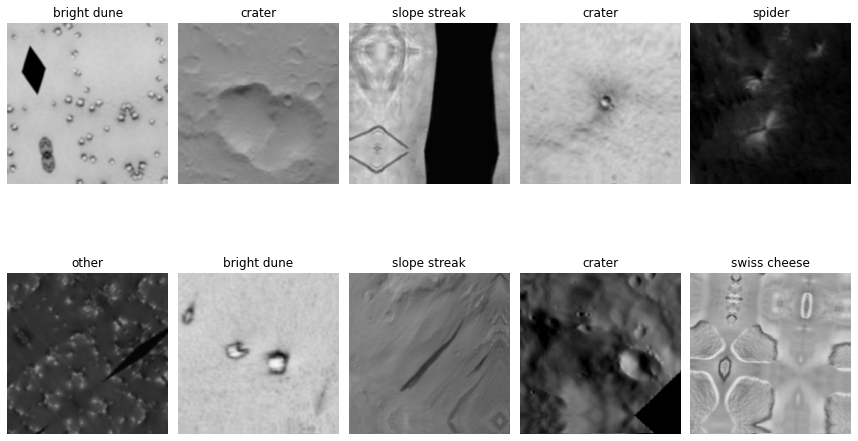

In [15]:
visualize_augmentations(train_dataset,np.random.randint(1,len(train_dataset)), random_img = True)


In [16]:
BATCH_SIZE = 64
train_iterator = DataLoader(train_dataset, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = DataLoader(valid_dataset, 
                                 batch_size = BATCH_SIZE)

# test_iterator = DataLoader(test_dataset, 
#                                 batch_size = BATCH_SIZE)

In [17]:
pretrained_model = models.resnet50(pretrained = True).to(dev)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
for param in pretrained_model.parameters():
    param.requires_grad = False 

In [20]:
IN_FEATURES = pretrained_model.fc.in_features 
pretrained_model.fc = nn.Sequential(
               nn.Linear(IN_FEATURES, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8)).to(dev)
pretrained_model.conv1 = torch.nn.Conv2d(1,64,kernel_size = (7,7),stride = (2,2), padding = (3,3), bias = False) .to(dev)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters())

In [22]:
datasets = {'train':train_dataset, 'valid':valid_dataset}

In [23]:
dataloaders = {'train': train_iterator, 'valid':valid_iterator}

In [24]:
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels,_ in dataloaders[phase]:
                inputs = inputs.float().to(dev)
                labels = labels.to(dev)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [27]:
model_trained = train_model(pretrained_model, criterion, optimizer, num_epochs=50)
torch.save(model_trained.state_dict(), 'undersampled_run_weights.h5')

Epoch 1/50
----------
train loss: 1.2255, acc: 0.5767
valid loss: 1.1540, acc: 0.5984
Epoch 2/50
----------
train loss: 1.2551, acc: 0.5582
valid loss: 1.1372, acc: 0.5951
Epoch 3/50
----------
train loss: 1.1358, acc: 0.5985
valid loss: 1.0272, acc: 0.6246
Epoch 4/50
----------
train loss: 1.0694, acc: 0.6325
valid loss: 1.0076, acc: 0.6295
Epoch 5/50
----------
train loss: 1.0406, acc: 0.6478
valid loss: 0.9584, acc: 0.6508
Epoch 6/50
----------
train loss: 1.0594, acc: 0.6317
valid loss: 0.9478, acc: 0.6377
Epoch 7/50
----------
train loss: 1.0644, acc: 0.6228
valid loss: 0.9885, acc: 0.6279
Epoch 8/50
----------
train loss: 1.0047, acc: 0.6422
valid loss: 0.9876, acc: 0.6508
Epoch 9/50
----------
train loss: 1.0153, acc: 0.6454
valid loss: 0.8945, acc: 0.6705
Epoch 10/50
----------
train loss: 0.9809, acc: 0.6624
valid loss: 0.9636, acc: 0.6492
Epoch 11/50
----------
train loss: 0.9776, acc: 0.6632
valid loss: 0.9209, acc: 0.6557
Epoch 12/50
----------
train loss: 0.9579, acc: 0.67

In [28]:
torch.save(model_trained.state_dict(), 'undersampled_run_weights.pth')

## Testing

In [31]:
import glob,random
images = glob.glob("/content/map-proj-v3/*.jpg")
test_img_labels = pd.read_csv('/content/labels-map-proj-v3.txt', delimiter=' ',header=None,names=['name','class'])
test_images = test_img_labels['name'].sample(n=3, random_state=1).tolist()


In [32]:
test_images

['ESP_028196_1840_RED-0119-r270.jpg',
 'ESP_016715_2025_RED-0077-r270.jpg',
 'ESP_016802_2190_RED-0380-fh.jpg']

In [33]:
labels = [1,3,0]

In [35]:
test_imgs = []
transform_test = transforms.Compose([
    transforms.ToTensor()
])
for img_path in test_images:
  image = cv2.imread('/content/map-proj-v3/'+img_path)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  test_imgs.append(gray_image)

In [36]:
validation_batch = torch.stack([transform_test(img).to(dev)
                                for img in test_imgs])

In [37]:
validation_batch

tensor([[[[0.5490, 0.5490, 0.5529,  ..., 0.5725, 0.5725, 0.5686],
          [0.5451, 0.5451, 0.5490,  ..., 0.5647, 0.5647, 0.5647],
          [0.5451, 0.5451, 0.5490,  ..., 0.5608, 0.5608, 0.5647],
          ...,
          [0.6431, 0.6431, 0.6392,  ..., 0.6039, 0.6039, 0.5961],
          [0.6510, 0.6510, 0.6431,  ..., 0.5961, 0.5961, 0.6000],
          [0.6549, 0.6549, 0.6431,  ..., 0.5882, 0.5961, 0.6039]]],


        [[[0.6353, 0.6314, 0.6196,  ..., 0.7098, 0.7059, 0.7059],
          [0.6235, 0.6196, 0.6157,  ..., 0.6980, 0.6980, 0.6980],
          [0.6196, 0.6118, 0.6078,  ..., 0.6980, 0.6980, 0.6980],
          ...,
          [0.4431, 0.4353, 0.4275,  ..., 0.5882, 0.6275, 0.6314],
          [0.4314, 0.4275, 0.4235,  ..., 0.3686, 0.4510, 0.5255],
          [0.4392, 0.4275, 0.4157,  ..., 0.3569, 0.2824, 0.2902]]],


        [[[0.4235, 0.4157, 0.4078,  ..., 0.4431, 0.4196, 0.4118],
          [0.4157, 0.4118, 0.4078,  ..., 0.4471, 0.4275, 0.4157],
          [0.4078, 0.4039, 0.4078,  ..

In [38]:
pred_logits_tensor = pretrained_model(validation_batch)

In [39]:
pred_logits_tensor

tensor([[ 2.2157, -3.0569,  3.5444,  1.9274, -5.5645, -0.9677, -3.5224,  1.5682],
        [ 2.2161, -3.0629,  3.5499,  1.9276, -5.5617, -0.9551, -3.5512,  1.5773],
        [ 2.2125, -3.0476,  3.5477,  1.9247, -5.5596, -0.9544, -3.5458,  1.5734]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [40]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

In [42]:
pred_probs

array([[1.63960546e-01, 8.41126661e-04, 6.19105279e-01, 1.22892596e-01,
        6.85211853e-05, 6.79507479e-03, 5.28077420e-04, 8.58087614e-02],
       [1.63312927e-01, 8.32500518e-04, 6.19829714e-01, 1.22381382e-01,
        6.84116967e-05, 6.85115019e-03, 5.10882295e-04, 8.62130672e-02],
       [1.63142443e-01, 8.47529678e-04, 6.20101154e-01, 1.22345738e-01,
        6.87388965e-05, 6.87375246e-03, 5.14992338e-04, 8.61057043e-02]],
      dtype=float32)

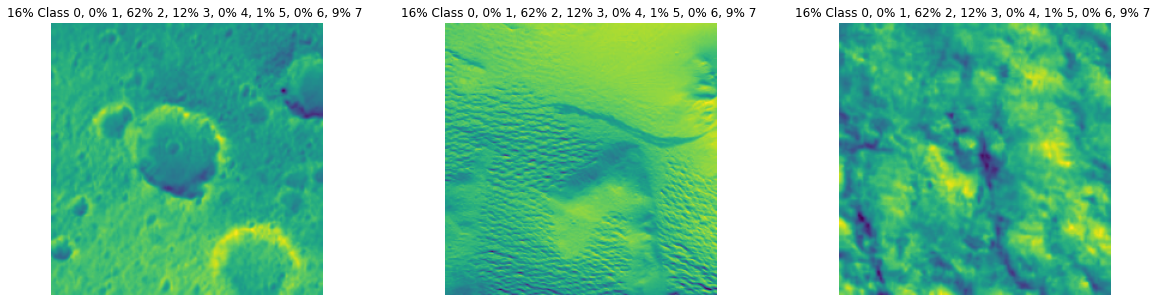

In [44]:
fig, axs = plt.subplots(1, len(test_imgs), figsize=(20, 5))
for i, img in enumerate(test_imgs):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Class 0, {:.0f}% 1, {:.0f}% 2, {:.0f}% 3, {:.0f}% 4, {:.0f}% 5, {:.0f}% 6, {:.0f}% 7 ".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1],
                                                            100*pred_probs[i,2],
                                                            100*pred_probs[i,3],
                                                            100*pred_probs[i,4],
                                                            100*pred_probs[i,5],
                                                            100*pred_probs[i,6],
                                                            100*pred_probs[i,7],))
    ax.imshow(img)

In [ ]:
# CLEARLY UNDERSAMPLING IS BAD !!